In [49]:
#import 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Setup most optimal model

In [50]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

df.drop(['id', 'floors',
         'heat_source','lat','long'], axis=1, inplace=True)

# Create zip from address
df['zip'] = [x.split(',')[2][-5:] for x in df['address']] 

#https://www.zillow.com/browse/homes/wa/king-county/  - remove all records with zipcodes that dont start with '98'
df = df[df.zip.str.startswith(('98'))]

df['city'] = [x.split(',')[1][0:] for x in df['address']]

#create sale year column from datetime date info
df['sale_year'] = pd.DatetimeIndex(df['date']).year.astype(int)

df['sale_year'].value_counts()


#create new column - age of house
df['home_age'] = (df['sale_year']+1) - df['yr_built']

#create new column - time since reno
df['yr_from_reno'] = (df['sale_year']+1) - df['yr_renovated']

# create filter for yr_from_reno to ID houses that haven't been renovated
reno_filter = df['yr_from_reno'] > 2000

# create new column for design_age to see time since build if no reno, or time since reno if renovated
# first set to reno age
df['design_age'] = df['yr_from_reno']
#then update columns where there was no reno to age of the home
df['design_age'].loc[reno_filter] = df['home_age']

#some houses were sold before they were built - we need to change those records to 0

prebuild_filter = df['design_age'] < 1

df['design_age'].loc[prebuild_filter] = 1


grade_cat = df[['grade']]
grade_categories = ['1 Cabin', '2 Substandard', '3 Poor', '4 Low', '5 Fair', '6 Low Average',
                    '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']
encoder_grade = OrdinalEncoder(categories=[grade_categories])
encoder_grade.fit(grade_cat)
grade_encoded_train = encoder_grade.transform(grade_cat)
grade_encoded_train = grade_encoded_train.flatten()
df["grade"] = grade_encoded_train

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [51]:
df_city = df.groupby('city').count()['price'].reset_index()
city_columns = df_city[ df_city['price'] < 30 ].transpose()
city_columns.columns = city_columns.iloc[0]
city_columns.columns

drop_city = list(city_columns.columns)

In [52]:
for city in drop_city:
    df = df[~df.city.str.contains(city)]

In [53]:
df = df.loc[df["grade"] > 5 ]
df = df.loc[df["grade"] < 11 ]

In [54]:
y = df["price"]
X = df.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

print(f"X_test is a DataFrame with {X_test.shape[0]} rows and {X_test.shape[1]} columns")
print(f"y_test is a Series with {y_test.shape[0]} values")

model = LinearRegression()

## Building Training Transformations

df.grade.value_counts()

# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
X_train.loc[df['bathrooms'] == 0, 'bathrooms'] = 1
X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)


# Create binary substitutes for columns
X_train['basement_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_basement']]
X_train['garage_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_garage']]
X_train['patio_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_patio']]
X_train['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in X_train['waterfront']]
X_train['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in X_train['sewer_system']]
X_train['yrenovated_binary'] = [1 if sq >  0 else 0 for sq in X_train['yr_renovated']]


# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = X_train[['greenbelt']]
encoder_greenbelt = OrdinalEncoder(categories=[['NO', 'YES']])
encoder_greenbelt.fit(greenbelt_cat)
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
X_train["greenbelt"] = greenbelt_encoded_train

nuisance_cat = X_train[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
X_train["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = X_train[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
X_train["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = X_train[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
X_train["view"] = view_encoded_train


# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
city_train = X_train[["city"]]

ohe = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe.fit(city_train)

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
city_encoded_train = ohe.transform(city_train)

# Replace None with appropriate code

# (4) Transform fireplace_qu_train using the encoder and
# assign the result to fireplace_qu_encoded_train
city_encoded_train = ohe.transform(city_train)

# Visually inspect fireplace_qu_encoded_train
city_encoded_train

# (5a) Make the transformed data into a dataframe
city_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    city_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_train.index
)

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("city", axis=1, inplace=True)

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, city_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
fireplace_qu_train = X_train[["zip"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe.fit(fireplace_qu_train)

# Inspect the categories of the fitted encoder
ohe.categories_

# Replace None with appropriate code

# (4) Transform fireplace_qu_train using the encoder and
# assign the result to fireplace_qu_encoded_train
fireplace_qu_encoded_train = ohe.transform(fireplace_qu_train)

# Visually inspect fireplace_qu_encoded_train
fireplace_qu_encoded_train

# Run this cell without changes

# (5a) Make the transformed data into a dataframe
fireplace_qu_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    fireplace_qu_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
fireplace_qu_encoded_train

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("zip", axis=1, inplace=True)

# Visually inspect X_train

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, fireplace_qu_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
X_train['total_sqft'] = X_train['sqft_above'] + X_train['sqft_basement'] + X_train['sqft_garage'] + X_train['sqft_patio']

X_train['weighted__livsqft'] = X_train['sqft_living'] * X_train['grade']

X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')

X_train['date'].head()

#create sale year column from datetime date info
X_train['sale_year'] = pd.DatetimeIndex(X_train['date']).year.astype(int)

X_train['sale_year'].value_counts()

#Binning by decade

X_train['design_decade'] = pd.cut(x=X_train['design_age'], bins=[0, 3, 13, 23, 33, 43, 53, 63, 73,
                                                         83, 93, 103, 113, 123],
                    labels=['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s',
                            '1950s', '1940s', '1930s', '1920s', '1910s', '1900s'])

X_train.design_decade.value_counts()

labels_ordered = ['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s','1950s', '1940s', '1930s', '1920s', '1910s', '1900s']

labels_ordered.reverse()

labels_ordered

# Create Ordinal Values for view
# Using OneHotEncoder
age_cat = X_train[['design_decade']]
age_categories = labels_ordered
encoder_age = OrdinalEncoder(categories=[age_categories])
encoder_age.fit(age_cat)
encoder_age.categories_[0]

age_encoded_train = encoder_age.transform(age_cat)
age_encoded_train = age_encoded_train.flatten()
X_train["design_decade"] = age_encoded_train

X_train["design_decade"]

X_train['yard_size_ratio'] = (X_train['total_sqft'] / X_train['sqft_lot']) * 100

# list(X_train.columns)

X_train is a DataFrame with 19260 rows and 25 columns
y_train is a Series with 19260 values
X_test is a DataFrame with 6420 rows and 25 columns
y_test is a Series with 6420 values


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-54-6bf13d0f2aef>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)
<ipython-input-54-6bf13d0f2aef>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [55]:
relevant = ['view', 'condition', ' Algona', ' Auburn', ' Bellevue', ' Black Diamond', ' Bothell', ' Burien',
            ' Carnation', ' Clyde Hill', ' Covington', ' Des Moines', ' Duvall', ' Enumclaw', ' Fall City',
            ' Federal Way', ' Issaquah', ' Kenmore', ' Kent', ' Kirkland', ' Lake Forest Park', ' Maple Valley',
            ' Medina', ' Mercer Island', ' Newcastle', ' Normandy Park', ' North Bend', ' Pacific', ' Ravensdale',
            ' Redmond', ' Renton', ' Sammamish', ' SeaTac', ' Seattle', ' Shoreline', ' Snoqualmie', ' Tukwila',
            ' Vashon', ' Woodinville', 'greenbelt', 'weighted__livsqft', 'design_decade', 'nuisance','garage_binary',
            'basement_binary', 'patio_binary','PublicSewer_binary', 'waterfront_binary', 'yard_size_ratio']

X_train = X_train[relevant]

In [56]:
model_1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
results = model_1.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     869.5
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:14:04   Log-Likelihood:            -2.7753e+05
No. Observations:               19260   AIC:                         5.552e+05
Df Residuals:                   19211   BIC:                         5.555e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.377e+05   2.31e+04     10.271      0.000    1.92e+05    2.83e+05
view                8.339e+04   4280.153     19.484      0.000     7.5e+04    9.18e+04
condition           5.032e+04   5144.597      9.781      0.000    4.02e+04    6.04e+04
 Algona            -3.962e+05   9.35e+04     -4.236      0.000    -5.8e+05   -2.13e+05
 Auburn            -4.742e+05   1.53e+04    -30.913      0.000   -5.04e+05   -4.44e+05
 Bellevue           5.248e+05    1.5e+04     35.053      0.000    4.95e+05    5.54e+05
 Black Diamond     -5.064e+05   3.17e+04    -15.973      0.000   -5.69e+05   -4.44e+05
 Bothell            2.388e+04   3.08e+04      0.775      0.438   -3.65e+04    8.43e+04
 Burien              -2.8e+05   2.56e+04    -10.939      0.000    -3.3e+05    -2.3e+05
 Carnation         -2.283e+05   4.37e+04     -5.220      0.000   -3.14e+05   -1.43e+05
 Clyde Hill         2.343e+06   6.31e+04     37.112      0.000    2.22e+06    2.47e+06
 Covington         -3.944e+05   2.44e+04    -16.178      0.000   -4.42e+05   -3.47e+05
 Des Moines         -3.61e+05   2.66e+04    -13.594      0.000   -4.13e+05   -3.09e+05
 Duvall            -1.968e+05   3.23e+04     -6.096      0.000    -2.6e+05   -1.34e+05
 Enumclaw          -4.726e+05   2.77e+04    -17.081      0.000   -5.27e+05   -4.18e+05
 Fall City          2.178e+05    5.4e+04      4.034      0.000    1.12e+05    3.24e+05
 Federal Way       -4.902e+05   1.66e+04    -29.587      0.000   -5.23e+05   -4.58e+05
 Issaquah           1.104e+05   2.28e+04      4.846      0.000    6.58e+04    1.55e+05
 Kenmore            -4.05e+04   2.86e+04     -1.417      0.156   -9.65e+04    1.55e+04
 Kent              -4.217e+05   1.44e+04    -29.212      0.000    -4.5e+05   -3.93e+05
 Kirkland           4.309e+05   1.56e+04     27.685      0.000       4e+05    4.61e+05
 Lake Forest Park  -7.217e+04   3.48e+04     -2.072      0.038    -1.4e+05   -3888.346
 Maple Valley        -3.5e+05   1.84e+04    -18.980      0.000   -3.86e+05   -3.14e+05
 Medina             2.654e+06   7.39e+04     35.939      0.000    2.51e+06     2.8e+06
 Mercer Island       7.22e+05   2.81e+04     25.726      0.000    6.67e+05    7.77e+05
 Newcastle         -1.526e+04   3.74e+04     -0.408      0.683   -8.86e+04     5.8e+04
 Normandy Park      -3.29e+05   4.92e+04     -6.682      0.000   -4.26e+05   -2.33e+05
 North Bend        -2.331e+05   2.42e+04     -9.639      0.000   -2.81e+05   -1.86e+05
 Pacific           -3.795e+05   6.35e+04     -5.980      0.000   -5.04e+05   -2.55e+05
 Ravensdale        -3.621e+05   7.01e+04     -5.165      0.000   -4.99e+05   -2.25e+05
 Redmond            2.896e+05   1.75e+04     16.589      0.000    2.55e+05    3.24e+05
 Renton            -2.867e+05   1.38e+04    -20.739      0.000   -3.14e+05    -2.6e+05
 Sammamish          1.925e+05   1.75e+

4 assumptions of linear regression:

(i) linearity and additivity of the relationship between dependent and independent variables:

    (a) The expected value of dependent variable is a straight-line function of each independent variable, holding the others fixed.

    (b) The slope of that line does not depend on the values of the other variables.

    (c)  The effects of different independent variables on the expected value of the dependent variable are additive.

(ii) statistical independence of the errors (in particular, no correlation between consecutive errors in the case of time series data)

(iii) homoscedasticity (constant variance) of the errors

    (a) versus time (in the case of time series data)

    (b) versus the predictions

    (c) versus any independent variable

(iv) normality of the error distribution.

# Linearity

In [57]:
fitted_vals = model_1.predict()
resids = model_1.resid

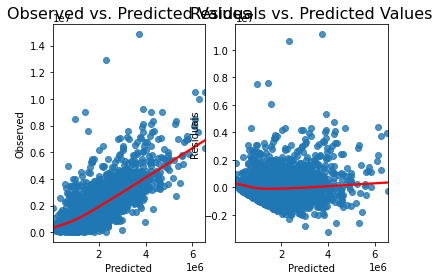

In [59]:
fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=y_train, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed');

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals');

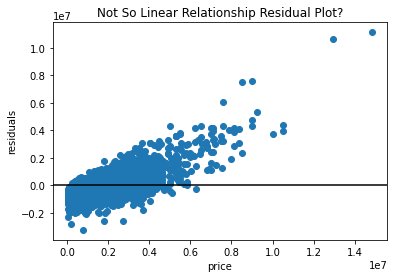

In [60]:
y = y_train
X = X_train

fig, ax = plt.subplots()


ax.scatter(y, model_1.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("price")
ax.set_ylabel("residuals")
ax.set_title("Not So Linear Relationship Residual Plot?");

In [61]:
# # fig = plt.figure(figsize=(15,5))
# sm.graphics.plot_partregress_grid(model_1, exog_idx=['view', 'condition', ' Algona', ' Auburn', ' Bellevue', ' Black Diamond', ' Bothell', ' Burien',
#             ' Carnation', ' Clyde Hill', ' Covington', ' Des Moines', ' Duvall', ' Enumclaw', ' Fall City',
#             ' Federal Way', ' Issaquah', ' Kenmore', ' Kent', ' Kirkland', ' Lake Forest Park', ' Maple Valley',
#             ' Medina', ' Mercer Island', ' Newcastle', ' Normandy Park', ' North Bend', ' Pacific', ' Ravensdale',
#             ' Redmond', ' Renton', ' Sammamish', ' SeaTac', ' Seattle', ' Shoreline', ' Snoqualmie', ' Tukwila',
#             ' Vashon', ' Woodinville', 'greenbelt', 'weighted__livsqft', 'design_decade', 'nuisance','garage_binary',
#             'basement_binary', 'patio_binary','PublicSewer_binary', 'waterfront_binary', 'yard_size_ratio'], fig=fig)

# fig.suptitle("Not So Linear Relationship Partial Regression Plot", fontsize="large")

# plt.tight_layout()
# plt.show();

### Rainbow test

In [62]:
# # Select subset of data
# n = linear_results.nobs

# # Taking the middle 50%, so ignoring the first 25% and last 25%
# lower_bound = int(np.ceil(n * 0.25))
# upper_bound = int(np.floor(n * 0.75))

# # Take subsets of y and X
# subset_y = linear_model.endog[lower_bound:upper_bound]
# subset_X = linear_model.exog[lower_bound:upper_bound]

# # Build model w/ subset
# subset_model = sm.OLS(subset_y, subset_X)
# subset_results = subset_model.fit()

# # Visualize subset
# fig, axes = plt.subplots(ncols=2, figsize=(15,5))

# axes[0].scatter(linear_model.endog, linear_results.resid, color="green")
# axes[0].set_title("Full Data Residual Plot")

# axes[1].scatter(subset_y, subset_results.resid, color="green")
# axes[1].set_title("Subset Residual Plot")

# for ax in axes:
#     ax.set_xlabel("y")
#     ax.set_ylabel("residuals")
#     ax.axhline(y=0, color="black")

# # Compare residual sum of squares
# subset_n = subset_model.nobs

# rss = linear_results.ssr
# subset_rss = subset_results.ssr

# stat = (rss - subset_rss) * subset_results.df_resid / ((n - subset_n) * subset_rss) 
# stat

# # Find pval for above stat
# p_value = stats.f.sf(stat, n - subset_n, subset_results.df_resid)
# p_value

In [63]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(model_1)

(1.134594670616711, 3.0973140629231376e-10)

Since the p value is below alpha, we reject the null hypothesis and do not consider the relationship to be linear. We will need to perform a non-linear transformation on either the target and/or features.

# Independence

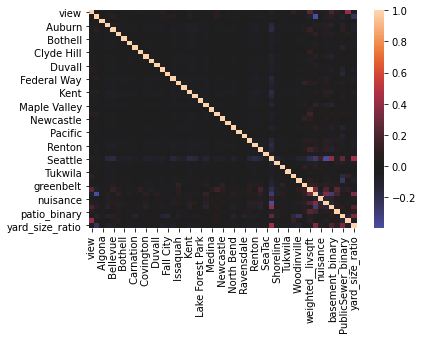

In [64]:
sns.heatmap(X_train.corr(), center=0);

In [65]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_corr=X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

# set index to pairs
df_corr.set_index(['pairs'], inplace = True)

#d rop level columns
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_corr.drop_duplicates(inplace=True)

df_corr[(df_corr.cc>.75) & (df_corr.cc <1)]

,cc
pairs,


We can see that we have no correlation between variables above 0.75, and so we can say that there is no multicollinearity.

# Normality

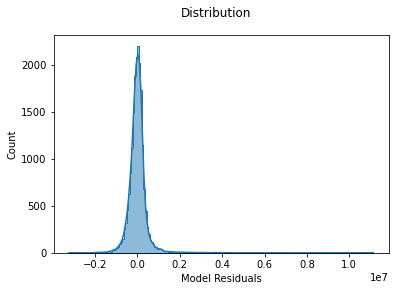

In [66]:
# Histogram of residuals
fig, ax = plt.subplots()
sns.histplot(model_1.resid, bins=200, element="step", kde=True, ax=ax)
ax.set_xlabel("Model Residuals")
fig.suptitle("Distribution");

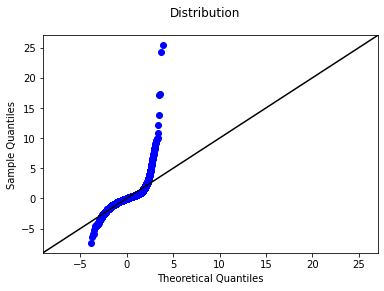

In [67]:
# Q-Q plot
# Use qqplot function from StatsModels
fig, ax = plt.subplots()
sm.graphics.qqplot(model_1.resid, dist=stats.norm, line='45', fit=True, ax=ax)

# Customize plot appearance
line = ax.lines[1]
line.set_color("black")
fig.suptitle("Distribution");

In [68]:
from statsmodels.stats.stattools import jarque_bera
jarque_bera(model_1.resid)

(3612130.458026683, 0.0, 4.129222139444256, 69.57999130407707)

To determine the normality of the model, we can look at the histogram of residuals and QQ plot. We can also reference the Jarque-Bera test results.

JB: 3612130

P(JB): 0.0

We can reject the null hypothesis as the residual P value is below alpha, and so the distribution is not normal.

The fix is to transform non-normal features or the target by applying a log transform.

# Equal Variance(Homoskedacity)

In [72]:
# Build a simple linear regression model and extract slope + intercept
# to get the best-fit line
# slope = model_1.params['price']
# intercept = model_1.params["const"]
# fit_line = slope * x_mpg + intercept



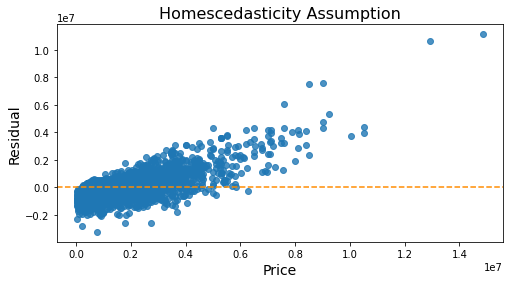

In [75]:
# Plotting the residuals
plt.subplots(figsize=(8, 4))
plt.scatter(x=y_train, y=model_1.resid, alpha=0.8)
plt.axhline(y=0, color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.title('Homescedasticity Assumption', fontsize=16)
plt.show();

In [45]:
# Goldfeld-Quandt test:
from statsmodels.stats.diagnostic import het_goldfeldquandt

het_goldfeldquandt(y_train, X_train, alternative='two-sided')

(0.9943119873684759, 0.7801174842851333, 'two-sided')

For this data, we have a p value of about 0.78. We cannot reject the null hypothesis, so the data is homoscedastic.